<a href="https://colab.research.google.com/github/mabonmn/Googe_Net_Top5_Prob/blob/main/Frame_prob_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this code is to analyse the impact of the different features on the probablity(particulary the top 5) of a particulare frame in a video and how that top 5 catg. changes through the course of the video.

# Packages and Drive Mount

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import cv2
import numpy as np
import os
import pandas as pd
from PIL import Image
import os
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

Mounted at /content/drive
--2022-03-30 19:48:11--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-03-30 19:48:11 (92.3 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



# Add path to folder with frames(images etc)
# CHANGE ONLY THIS IS RECOMENDED

In [3]:
dir='/content/drive/MyDrive/Feature Extraction - Mabon/Top_five_prob/1/'
Number_Of_Top5_To_Graph=4

# FOR VIDEO UPLOADS ONLY

In [5]:
'''
#UPDATE ONLY THE NEXT LINE
vid_path='/content/10.mp4'

path='/content/temp'
isExists = os.path.exists(path)
if not isExists:
  os.makedirs(path)
  print(" The directory was created successfully")
else:
  print(" Directory already exists")


vc = cv2.VideoCapture(vid_path)
number_of_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
print(number_of_frames)
for c in range(number_of_frames):  
  rval, frame = vc.read()
  if (c % 15 == 0):  
    
    cv2.imwrite("%s/"%path+ str(int(c / 15)) + '.png', frame)
dir=path+'/'
'''      

 Directory already exists
9721


# Initialisation 

In [6]:

files = next(os.walk(dir))[2] #dir is your directory path as string
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]   
 
top5_prob=0
top5_catid=0
frame_chk=0                    #frames whose key features you want to check
prob=[]
prob2=[]
a=[]
plots=[]

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()
print(" ")

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

# Original Method

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:

for i in range(len(files)):
    path1=dir+str(i)+'.png'
    input_image = Image.open(path1)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)
    #frame prob using recomended extration from torch.hub
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    if(i==frame_chk):
        top5_prob, top5_catid = torch.topk(probabilities, 5)
    prob.append(np.array(probabilities))
#All Prob are stored in a pandas dataframe
probabilities_dataframe = pd.DataFrame(np.array(prob))

# Proposed Method

In [10]:
temp = Image.open(dir+'1.png')
w,h=temp.size

s=((224+40)*h)/w
preprocess2 = transforms.Compose([
    transforms.Resize(int(s)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:

for i in range(len(files)):
    path1=dir+str(i)+'.png'
    input_image = Image.open(path1)
    input_tensor = preprocess2(input_image)
    input_batch = input_tensor.unsqueeze(0)       # create a mini-batch as expected by the model
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    prob2.append(np.array(probabilities))
probabilities_dataframe2 = pd.DataFrame(np.array(prob2))

# Plots

In [12]:
# Show top categories per image
print("FOLLOWING ARE THE TOP 5 CATEGORIES OF THE FRAME WE HAVE CHOSEN TO VIEW :")
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]])

FOLLOWING ARE THE TOP 5 CATEGORIES OF THE FRAME WE HAVE CHOSEN TO VIEW :
amphibian
speedboat
lakeside
boathouse
dock


In [13]:
x = np.array(list(range(len(files))))

for i in range(Number_Of_Top5_To_Graph):
  plots.append(np.array(probabilities_dataframe[int(top5_catid[i])]))
  plots.append(np.array(probabilities_dataframe2[int(top5_catid[i])]))
  a.append(categories[int(top5_catid[i])]+" :Original Crop")
  a.append(categories[int(top5_catid[i])]+" :Sugested Crop")



In [14]:
df = pd.DataFrame(data=plots)
df=df.transpose()
df.columns=a
fig=df.plot()
fig.update_layout(
        title="Probability Graph",
        xaxis_title="Frames",
        yaxis_title="Probability",
        legend_title="Reference",
        yaxis=dict(range=[0,1]),
    )

fig.show()

# Sample Image AS Per Recomended Crop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


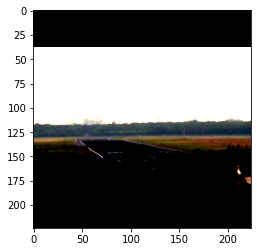

In [28]:

#sample image crop
path1=dir+str(0)+'.png'
input_image = Image.open(path1)
input_tensor = preprocess2(input_image)
plt.imshow(input_tensor.permute(1, 2, 0))
